(sec:deep-learning)=
# 深層学習による物体認識

前回、[特徴量抽出](sec:feature-extraction)では、画像から特徴量を検出し、それを画像認識に利用する方法を見てきた。

2000年台まで、画像認識の分野では、**画像を如何に特徴化するか**と**得られた特徴からどのように物体を認識するか**という二つの研究が中心となってきた。

そのために、SIFTを始めとする特徴量の改善や、カーネル法を用いたSVMの性能改善などが試みられてきたが、その性能は徐々に頭打ちになっていく。

**深層学習の歴史**

そんな折、彗星のごとく現れた技術がニューラルネットワークを多層化した深層学習である。実は、ニューラルネット自体は人間の脳のシナプス同士の結合を模したモデルとして1950年代から研究されていた。

最初にニューラルネットが日の目を見たのは1980年代で、この頃には、入力層、隠れ層、出力層の三層を持つニューラルネットがある程度の性能を出せることが知られていた。当然ながら、その当時も、より多層のニューラルネットワークを利用しようという考え自体はあり、検討が試みられたが、ニューラルネットワークの持つ多数のパラメータを上手く最適化する手法がなく、その時代には実現が難しいと考えられていた。

なお、多層のニューラルネットの考え方を最初に提唱したのは、当時NHKの放送技術研究所の研究員であった福島邦彦氏であるとされており、その論文は、驚くべきことに1980年に出版されている {cite}`fukushima1980neocognitron`。

2010年代に入ると、それまで下火だったニューラルネットが再び注目を集めることになる。それまで細々と続けられていたニューラルネットワークの研究の中で、パラメータの過学習や、最適化時の勾配消失といった問題が徐々に解決されるとともに、GPUを用いた汎用計算であるGPGPU (General Purpose Computing on GPU)により並列計算の公立が大幅に上昇するなど、ニューラルネットワークを取り巻く環境が徐々に変化してくる。そして、2012年に事件が起こる。

ImageNetと呼ばれる大規模画像データセットの識別チャレンジであるILSVRC (ImageNet Large Scale Visual Recognition Challenge)において、トロント大学のGeoffrey Hintonらの研究チームが、AlexNet (筆頭著者のfirst nameから)と呼ばれる二股のニューラルネットを用いて、2位のエラー率26.2%に大差をつけ、エラー率わずか17.0％を達成し、優勝する {cite}`krizhevsky2012imagenet`。この時の2位のチームが用いた手法はSIFT, Fisher Vector, SVMを組み合わせたものであった。

この優勝を皮切りに、2013年の大会ではオックスフォード大学のチームがVGGというネットワークで2位に入り、以後、2014年はGoogleのチームがGoogLeNetというネットワークで2位、2015年はMicrosoftのチームがResNetというネットワークで優勝する。

こうして、2016年くらいになると、現在のニューラルネットワークの構築において一般的になっている諸技術、例えば、

- Rectified Linear Unit (ReLU)
- Max Pooling
- Dropout
- Batch Normalization
- Skip Connection (Residual Block)
- Adaptive Momentum Estimation (Adam)

などの技術が、一通り出そろう。

さらには、この頃になるとNVIDIAのCaffeや、モントリオール大学のtheano、FacebookのTorch、そしてPreferred NetworkのChainerといった汎用の深層学習用ライブラリが多数登場する。これによって、深層学習の研究が一気に花開き、現在に至る。

---
**下準備のコード**

In [15]:
import os

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from myst_nb import glue
from tqdm.notebook import tqdm

# 実験に使うサンプル数
n_samples = 30000
glue("n_samples", n_samples, display=False)

# グラフの設定
matplotlib.rcParams["figure.dpi"] = 150
sns.set(style="white", palette="colorblind")

**平仮名73文字データセットの準備**

In [12]:
import zipfile

import requests

url = "http://lab.ndl.go.jp/dataset/hiragana73.zip"
filename = os.path.basename(url)

# HTTPリクエストを送ってデータサイズを取得
r = requests.get(url, stream=True)
total_size = int(r.headers.get("content-length", 0))
chunk_size = 65535

# "hiragana73"フォルダが存在し、その中身が空でないことを確認
if not os.path.exists("./hiragana73") or len(os.listdir("./hiragana73")) == 0:
    # 実際のファイルのダウンロード
    pbar = tqdm(total=total_size, unit="B", unit_scale=True)
    with open(filename, "wb") as f:
        for data in r.iter_content(chunk_size):
            f.write(data)
            pbar.update(chunk_size)

    # ダウンロードが完了したらZIPを展開する
    with zipfile.ZipFile(filename, "r") as f:
        f.extractall()

## PyTorchの各種モジュール

PyTorchには、いくつかのモジュールが用意されており、代表的なものが、

- `torch`
- `torch.nn`
- `torch.nn.functional`

の3つである。慣例的に、これらをこのような形でエイリアスを与えてインポートする。

In [9]:
# PyTorchのモジュール群
import torch
import torch.nn as nn
import torch.nn.functional as F

`torch`モジュールがテンソルデータそのもの(`torch.Tensor`等)や、データに対する操作 (`torch.exp`や`torch.transpose`等)が含まれる。

`torch.nn`モジュールには、ニューラルネットワークを構成するレイヤー (`nn.Linear`や`nn.Conv2d`等)や損失関数 (`nn.CrossEntropyLoss`や`nn.MSELoss`等)が含まれる。

`torch.nn.functional`モジュールには、`torch.nn`モジュールに含まれるクラス定義に対応する関数が用意されている。例えば`nn.Linear`に対応する関数として`F.linear`、`nn.MSELoss`に対応する関数として`F.mse_loss`、といった具合である。

また、インストールすることは必須ではないが、PyTorchに付属するライブラリにTorchVisionがある。TorchVisionは、主にコンピュータ・ビジョンへの応用を目的とした補助関数が多数用意されている。

これ以外にも、有名ネットワークモデルの学習済み重みなどが提供されており、`AlexNet`や`ResNet50`等のほか、`ViT`などの比較的新しいものも含まれている。

本資料では、画像の前処理に使う`transforms`モジュールだけを用いる。

In [11]:
# TorchVision
from torchvision import transforms

## 自動微分

PyTorchに限らず、深層学習を支える重要な技術に**自動微分**がある。関数の微分は、損失関数の最小化といった最適化問題にとって重要な情報であり、例えば、最急降下法やニュートン法といったアルゴリズムは、それぞれ関数の1階微分 (勾配)と、2階微分 (Hesse行列)を用いる。

しかし、このような微分を求めるには、数学的に関数の微分を求めておく必要があり、特に関数が複雑な場合には、それを求めることは困難である (が、従来はMathematicaなどのソフトを使って、勾配を求めるコードを書き出していた)。

また、1階微分であれば、差分法によって近似をすることも可能ではあるが、数値精度の問題は残る。2階微分以上になると差分計算の誤差が蓄積していくため、数値的に満足な結果を得ることは非常に難しくなる。

**自動微分**は、

In [4]:
# 変数を作成後、自動微分を有効にする
x = torch.Tensor([2.0])
x.requires_grad_(True)

# y = f(x) = x^3の計算
y = x * x * x
print("The value of y = f(x) is {:.1f}".format(y.item()))

# 微分の計算
y.backward()
print("The value of dy/dx is {:.1f}".format(x.grad.item()))

The value of y = f(x) is 8.0
The value of dy/dx is 12.0


**Rosenbrock関数**

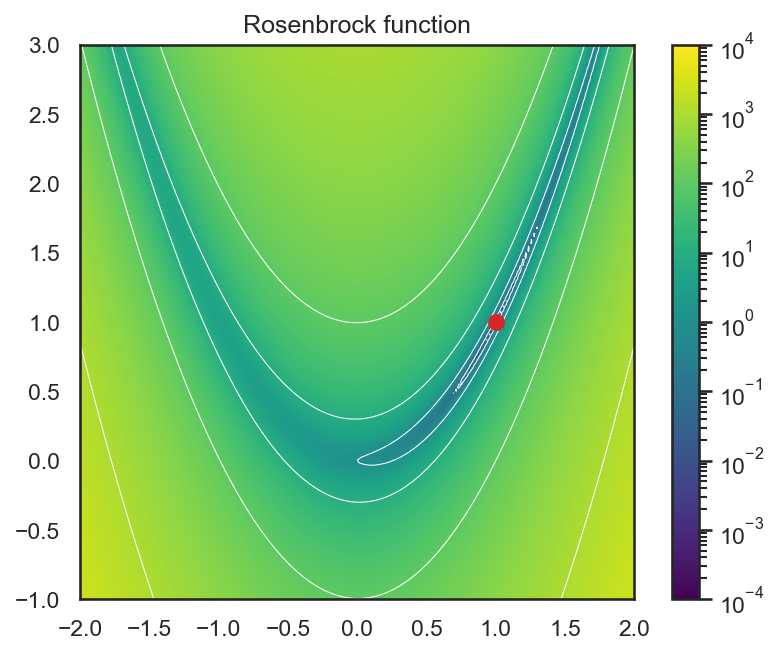

In [65]:
from matplotlib.colors import LogNorm

xs = np.linspace(-2.0, 2.0, 200)
ys = np.linspace(-1.0, 3.0, 200)
xs, ys = np.meshgrid(xs, ys)
extent = (-2.0, 2.0, -1.0, 3.0)
rosen = (1.0 - xs) ** 2.0 + 100.0 * (ys - xs**2.0) ** 2.0

fig, ax = plt.subplots()
mappable = ax.imshow(np.flip(rosen, axis=0), cmap="viridis", extent=extent, norm=LogNorm(vmin=1e-4, vmax=1.0e4))
ax.set(title="Rosenbrock function")
ax.contour(xs, ys, rosen, colors=["white"], linewidths=[0.5], norm=LogNorm(vmin=1e-4, vmax=1.0e4))
ax.scatter([1.0], [1.0], s=50, marker="o", color="tab:red", zorder=100)
fig.colorbar(mappable, ax=ax)
plt.show()

### データローダの作成

In [10]:
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader


class HiraganaDataset(Dataset):
    def __init__(self, dataroot, transform=None):
        super(HiraganaDataset, self).__init__()

        self.dataroot = dataroot
        self.transform = transform

        folders = sorted([d for d in os.listdir(self.dataroot)])
        chars = [chr(int(d.replace("U", "0x"), 16)) for d in folders]
        n_chars = len(chars)
        char2num = {c: i for i, c in enumerate(chars)}

        folders = [os.path.join(self.dataroot, d) for d in folders]
        self.data = []
        for d in folders:
            char = os.path.basename(d).replace("U", "0x")
            char = chr(int(char, 16))
            num = char2num[char]

            image_files = [os.path.join(d, f) for f in os.listdir(d)]
            image_files = [f for f in image_files if f.endswith(".png")]
            image_files = sorted(image_files)
            self.data.extend([(f, num) for f in image_files])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_file, num = self.data[idx]
        image = Image.open(image_file)
        if image is None:
            raise IOError("Failed to load image: {:s}".format(f))

        if self.transform is not None:
            image = transform(image)

        return image, num

### ネットワークの構築

In [6]:
class Network(nn.Module):
    def __init__(self, in_features, out_features):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(in_features, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, out_features)

    def forward(self, x):
        x = self.bn1(self.fc1(x))
        x = torch.relu(x)
        x = self.bn2(self.fc2(x))
        x = torch.relu(x)
        x = self.fc3(x)
        y = F.log_softmax(x, dim=1)
        return y

### 学習の準備

In [ ]:
batch_size = 32

transform = transforms.Compose(
    [
        transforms.Grayscale(),
        transforms.RandomAffine(degrees=[-90, 90], scale=[0.8, 1.1]),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float32),
    ]
)

dataset = HiraganaDataset(dataroot="hiragana73", transform=transform)

例のごとく、最初の{glue}`n_samples`個のデータだけを実験に用いる。

In [18]:
train_data, dataset = torch.utils.data.random_split(dataset, [n_samples, len(dataset) - n_samples])
test_data, _ = torch.utils.data.random_split(dataset, [n_samples, len(dataset) - n_samples])
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

### 最適化手法の設定

In [21]:
net = Network(48 * 48, 73)
optim = torch.optim.Adam(net.parameters(), lr=1.0e-3)

### 誤差関数の設定

In [23]:
criterion = nn.NLLLoss()

In [24]:
pbar = tqdm(train_loader)
for data in pbar:
    X, y_true = data
    X = X.reshape((X.size(0), -1))
    y_pred = net(X)
    loss = criterion(y_pred, y_true)
    acc = (torch.argmax(y_pred, dim=1) == y_true).float().mean()

    pbar.set_description("loss={:1.3f}, acc={:1.3f}".format(loss.item(), acc.item()))

    optim.zero_grad()
    loss.backward()
    optim.step()

    pbar.update()

  0%|          | 0/312 [00:00<?, ?it/s]

In [25]:
pbar = tqdm(test_loader)
n_succ = 0
for data in pbar:
    X, y_true = data
    X = X.reshape((X.size(0), -1))
    y_pred = net(X)
    n_succ += (torch.argmax(y_pred, dim=1) == y_true).float().sum()

print("Acc: {:.3f}".format(n_succ / len(test_data)))

  0%|          | 0/313 [00:00<?, ?it/s]

Acc: 0.291


## 畳み込みニューラルネット

In [20]:
class CNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 32, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc3 = nn.Linear(12 * 12 * 32, out_channels)

    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = torch.relu(x)
        x = self.bn2(self.conv2(x))
        x = torch.relu(x)
        x = F.max_pool2d(x, 2)
        x = x.reshape((x.size(0), -1))
        x = self.fc3(x)
        y = F.log_softmax(x, dim=1)
        return y

In [27]:
net = CNN(1, 73)
optim = torch.optim.Adam(net.parameters(), lr=1.0e-3)

In [29]:
pbar = tqdm(train_loader)
for data in pbar:
    X, y_true = data
    y_pred = net(X)
    loss = criterion(y_pred, y_true)
    acc = (torch.argmax(y_pred, dim=1) == y_true).float().mean()

    pbar.set_description("loss={:1.3f}, acc={:1.3f}".format(loss.item(), acc.item()))

    optim.zero_grad()
    loss.backward()
    optim.step()

    pbar.update()

  0%|          | 0/312 [00:00<?, ?it/s]

In [31]:
pbar = tqdm(test_loader)
n_succ = 0
for data in pbar:
    X, y_true = data
    y_pred = net(X)
    n_succ += (torch.argmax(y_pred, dim=1) == y_true).float().sum()

print("Acc: {:.3f}".format(n_succ / len(test_data)))

  0%|          | 0/313 [00:00<?, ?it/s]

Acc: 0.504


## 参考文献

```{bibliography}
:filter: docname in docnames
```